In [9]:
import numpy as np
import cProfile
import matplotlib.pyplot as plt

from mpi4py import MPI
from time   import time

In [10]:
def fox(exponent: int) -> float:
    comm = MPI.COMM_WORLD  # get the communicator object
    size = comm.Get_size() # total number of processes
    rank = comm.Get_rank() # rank of this process

    np.random.seed(69)  # set the seed for the random numbers generator
                        # so that the same numbers are generated in each process 

    if rank == 0: # if the process is the master 

        MATRIX_SIZE = 2**exponent
        # generate two random matrix of size MATRIX_SIZE
        matrix_A    = np.random.randint(1000, 2000, (MATRIX_SIZE, MATRIX_SIZE)) 
        matrix_B    = np.random.randint(1000, 2000, (MATRIX_SIZE, MATRIX_SIZE)) 
        # initialize the matrix C with zeros
        matrix_C    = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=int)
        data        = (MATRIX_SIZE, matrix_A, matrix_B, matrix_C)
    else:
        data = None

    data = comm.bcast(data, root=0)                  # broadcast the data to all processes
    MATRIX_SIZE, matrix_A, matrix_B, matrix_C = data # unpack the data

    start_time = time()
    for row_i in range(MATRIX_SIZE): 
        # Each process calculates a row of the matrix C
        # The process with rank i calculates the row i of the matrix C
        # The row i of the matrix C is the sum of the rows of the matrix A multiplied by the matrix B

        if rank == row_i % size and rank < MATRIX_SIZE: # this ensures that each process calculates a row of the matrix C without repeating rows
            for i in range(MATRIX_SIZE):
                # a[row_i, row_i] gets shifted to the right by i positions
                # and b[row_i] gets shifted to the bottom by i positions
                col = (row_i + i) % MATRIX_SIZE
                matrix_C[row_i] += matrix_A[row_i, col] * matrix_B[col] 

        # The rows of the matrix C are distributed among the processes using the MPI_Allreduce function
        # The MPI_Allreduce function sums the rows of the matrix C calculated by each process
        comm.Allreduce(MPI.IN_PLACE, matrix_C[row_i], op=MPI.SUM)

    if rank == 0:
        end_time = time() - start_time
        return end_time

In [11]:

def graphs():
    times_MPI = {}
    times_SEC = {}
    for exponent in range(6, 9):
        times_MPI[exponent] = np.zeros(5)
        times_SEC[exponent] = np.zeros(5)
        for i in range(5):
            times_MPI[exponent][i] = fox(exponent)
            times_SEC[exponent][i] = fox(exponent)
    
    y = [np.mean(times_MPI[exponent]) for exponent in times_MPI]
    x = [exponent for exponent in times_MPI]
    x_labels = [str(2**exponent) for exponent in times_MPI]
    plt.figure(figsize=(10, 5))
    plt.title('Tiempo de ejecución del algoritmo Fox\nMatrices de números enteros.')
    plt.xlabel('Orden de la Matriz')
    plt.xticks(x, x_labels)
    plt.yticks([]) 
    bars = plt.bar(x, y, label='MPI')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.5}s', va='bottom', ha='center')  # va: vertical alignment

    plt.show()

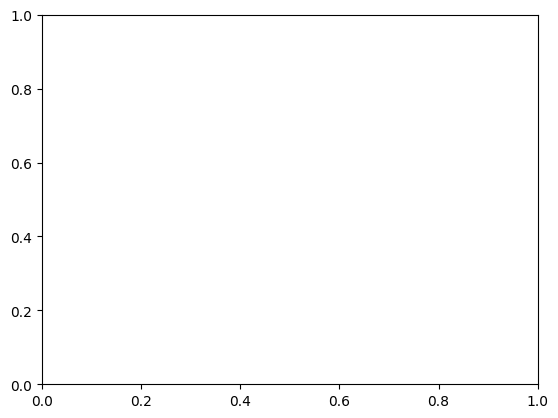

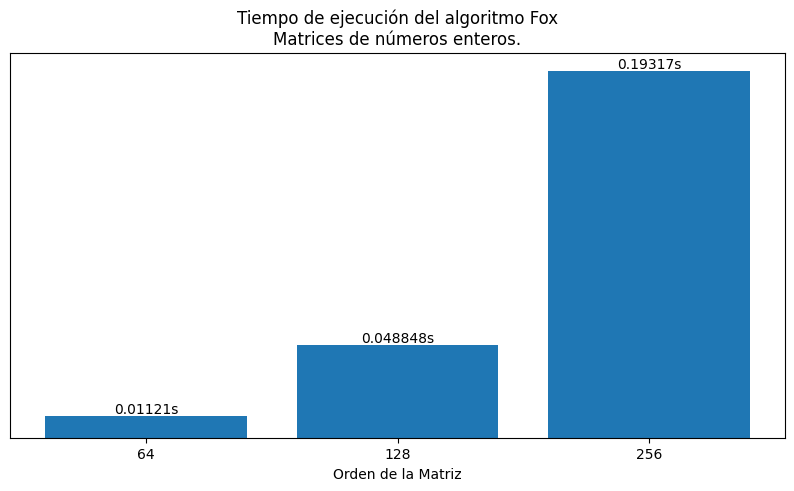

In [12]:
graphs()